# load packages

In [5]:
from cvae_models import VAE
from utils import PSNR,DateSet, numpy2gpu,load_split_data
from torch.utils.data import DataLoader,random_split

# 自动重新导入最新的外部文件
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load problem setup and data

In [6]:
%run problem_setting.py
print("数据OK!!!" if os.path.exists(hypers['data_file_prefix']+"_0.npz") else '\n\n需要生成训练数据!!!!') 

        image_size: 64
noise_signal_ratio: [0.01, 0.1]
         noise_num: 3
M_samples_per_para: 10000
          mu_range: [0.5, 0.5]
           mu_nums: 1
       gamma_range: [0.2, 0.2]
        gamma_nums: 1
           d_range: [0.15625, 0.15625]
            d_nums: 1
            t_in_G: 0.04
            r_in_G: 4
                 G: (4096, 4096)
             distM: (4096, 4096)
  data_file_prefix: data/deblur_size64_mu1_0.5_0.5_gamma1_0.2_0.2_d1_0.1562_0.1562_M10000
          data_dim: 4096
             x_dim: 4096
---------------------------------------------------------------------------
number of samples: 3*  10000  (noise_num*mu_nums*gamma_nums*d_nums*M_samples_per_para)
---------------------------------------------------------------------------
数据OK!!!


In [7]:
hypers['data_file_prefix']

'data/deblur_size64_mu1_0.5_0.5_gamma1_0.2_0.2_d1_0.1562_0.1562_M10000'

In [46]:
thetas, xs, ys = load_split_data(hypers,debug=True)

load data:0 
 (30000, 4) (30000, 4096) (30000, 4096)


In [86]:
thetas_noise = thetas[:,3]
thetas_noise = np.reshape(thetas_noise,(30000,1))
thetas_noise

array([[0.01],
       [0.01],
       [0.01],
       ...,
       [0.1 ],
       [0.1 ],
       [0.1 ]], dtype=float32)

# train model

In [ ]:
hyper_num = 1   #??
args ={"epochs":10,
       "batch_size": 180,
       "encoder_layer_sizes": [hyper_num,100,200,400,800,1600],
       "decoder_layer_sizes": [1600,800,400,100,hyper_num],
       "latent_size": 10,
       "print_every": 5000,
       "fig_root": 'figs',
       "conditional": True
       }
e = args['epochs']
s = hypers['image_size']
model_file_name = os.path.join('saved_model',f'cave_deblur_size{s}_epoch{e}_9_1') #??
print(f"total data size:{len(thetas)*args['epochs']}\nbatch_per_epoch:{len(thetas)//args['batch_size']}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# #******************************
# import random
# def setup_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True
# # 设置随机数种子
# setup_seed(20)
# #************************************

# data
ds = DateSet(thetas=thetas_noise,xs=xs,ys=ys)   #??

train_size = int(len(thetas)*0.9)
test_size = len(thetas)-train_size

ds_train,ds_test = random_split(ds,[train_size,test_size])
train_loader = DataLoader(ds_train,batch_size=args['batch_size'],shuffle=True)

test_loader = DataLoader(ds_test,batch_size=args['batch_size'],shuffle=False)

next(iter(test_loader))

theta_test, unkown_test, data_test = next(iter(test_loader))
num_test = 1000
x_test,y_test = theta_test.to(device)[:num_test,:],torch.cat((unkown_test,data_test),dim=1).to(device)[:num_test,:]

# model
vae = VAE(encoder_layer_sizes=args['encoder_layer_sizes'],
          latent_size=args['latent_size'],
          decoder_layer_sizes=args['decoder_layer_sizes'],
          conditional=args['conditional'],
          num_labels=y_test.shape[-1] if args['conditional'] else 0).to(device)

recon_loss = torch.nn.MSELoss(reduction='sum')

# loss
def loss_fn(recon_x, x, mean, log_var,kl_weight=0.5):
    BCE = recon_loss(recon_x.view(-1, hyper_num), x.view(-1, hyper_num))
    RMSE = torch.sqrt(BCE/x.size(0))/torch.sum(torch.abs(x))  # defined from DeepAR, 原因是各个参数尺度不一样，所以要归一化
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RMSE + kl_weight*KLD/ x.size(0)


# optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0000008)
# optimizer = torch.optim.SGD(vae.parameters(), lr=0.00004)

loss_epoch_mean = []
for epoch in range(args['epochs']):
# for epoch in range(2):
    epoch_loss = 0
    for iteration, (theta, unkown, data) in enumerate(train_loader):
        x, unkown, data = theta.to(device),unkown.to(device), data.to(device)
        y = torch.cat([unkown,data],dim=1)
        recon_x, mean, log_var, z = vae(x, y)
        loss = loss_fn(recon_x, x, mean, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if iteration % args['print_every'] == 0 or iteration == len(train_loader)-1:
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(epoch, args['epochs'], iteration, len(train_loader)-1, loss.item()))
            c = y_test
            z = torch.randn([c.size(0), args['latent_size']]).to(device)
            x_predict = vae.inference(z, c=c)
#           print(f"{np.linalg.norm(x_predict.detach().cpu().numpy()-x_test.cpu().numpy())}")
    loss_epoch_mean.append(epoch_loss/len(train_loader))
plt.plot(loss_epoch_mean)

total data size:300000
batch_per_epoch:166
Epoch 00/10 Batch 0000/149, Loss    0.0879
Epoch 00/10 Batch 0149/149, Loss    0.0161
Epoch 01/10 Batch 0000/149, Loss    0.0168
Epoch 01/10 Batch 0149/149, Loss    0.0129
Epoch 02/10 Batch 0000/149, Loss    0.0127
Epoch 02/10 Batch 0149/149, Loss    0.0109
Epoch 03/10 Batch 0000/149, Loss    0.0108
Epoch 03/10 Batch 0149/149, Loss    0.0096
Epoch 04/10 Batch 0000/149, Loss    0.0096


Text(0, 0.5, 'percentage error')

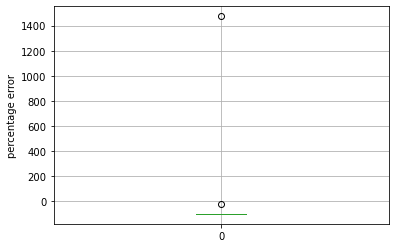

In [136]:
# predict

pe = (x_predict.detach().cpu().numpy()-x_test.cpu().numpy())/x_test.cpu().numpy()*100
_ = pd.DataFrame(pe).boxplot()
plt.ylabel('percentage error')

In [134]:
print(x_predict-x_test)
print(x_test)
print(x_predict)

tensor([[-1.5521e-02],
        [-5.5000e-02],
        [-9.6503e-02],
        [-5.5000e-02],
        [-5.5000e-02],
        [-1.0000e-02],
        [-1.0000e-01],
        [-1.0000e-02],
        [-4.0094e-02],
        [ 3.0900e-02],
        [-5.5000e-02],
        [-1.0000e-01],
        [-1.0000e-01],
        [-1.0000e-02],
        [-4.3153e-03],
        [ 3.3215e-02],
        [-5.5000e-02],
        [ 5.9950e-02],
        [ 7.8735e-02],
        [ 5.5690e-02],
        [-2.7732e-02],
        [-1.0000e-02],
        [-3.2328e-02],
        [-1.9448e-02],
        [-8.9537e-03],
        [-1.0000e-01],
        [ 9.5346e-02],
        [-1.2081e-02],
        [ 2.2062e-02],
        [-2.0585e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [ 3.4313e-02],
        [-5.5000e-02],
        [ 1.1011e-02],
        [-2.3914e-03],
        [-1.0000e-01],
        [-8.7044e-03],
        [-1.0000e-02],
        [ 1.5509e-02],
        [ 5.8714e-02],
        [-1.0000e-01],
        [ 1.9798e-03],
        [-4

In [38]:
(x_predict-x_test)/x_test

tensor([[-9.3370e-02, -2.2807e-01, -2.4330e-01, -6.4340e-01],
        [ 4.1377e-02,  1.1785e-02, -3.2084e-02,  4.5456e-02],
        [ 1.2513e-01, -3.1232e-03,  1.7641e-01, -6.7018e-02],
        [ 8.3313e-02, -1.0609e-01,  6.7524e-02,  7.8151e+00],
        [ 5.3033e-02, -1.6162e-01,  3.2056e-02,  7.2455e+00],
        [-5.1965e-02, -1.7497e-02, -4.0850e-02, -1.6037e-01],
        [-1.4863e-02,  1.5661e-01,  2.9193e-01,  5.8085e+00],
        [ 2.8919e-03,  1.0404e-02, -2.6567e-01,  4.3938e+00],
        [ 1.6436e-02, -8.3208e-02, -6.9384e-02,  4.3539e+00],
        [-9.8792e-02, -2.6596e-01,  7.4647e-02,  1.2799e-01],
        [ 4.0586e-03,  8.9075e-02, -2.4477e-01,  9.3933e-02],
        [ 7.8139e-03, -5.4857e-02,  1.5809e-02,  4.7358e+00],
        [ 5.3285e-02,  3.4855e-02,  2.2427e-01,  2.3245e+00],
        [-3.8683e-02,  3.2594e-02,  5.6925e-02, -6.2393e-01],
        [ 7.8671e-02, -1.6153e-01, -1.6799e-01, -8.7429e-01],
        [ 3.3403e-02, -2.2378e-02, -8.7923e-02, -9.1585e-02],
        

# 保存模型及参数

In [10]:
print(f"model_file_name:{model_file_name}")

model_file_name:saved_model/cave_deblur_size64_epoch10_8_31


In [11]:
torch.save(vae,model_file_name+'_one.pth')
np.save(model_file_name+'_args',args)
np.save(model_file_name+'_hypers',hypers)

In [12]:
ls saved_model/*.pth |grep deblur

saved_model/cave_deblur_size64_epoch10_8_31_one.pth
saved_model/cave_deblur_size64_epoch10_8_31.pth
